In [321]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import glob
from statsmodels.graphics.tsaplots import acf
from scipy.signal import periodogram
from scipy.spatial import distance
from sklearn.linear_model import LinearRegression
from sklearn import metrics



import Lyapunov_funcs ### Functs from Lyapunov proof of concept notebook

# Get data

In [93]:
path = "/Users/calumthompson/Documents/Final year project/Data/S&P500 March2015+/*"   #put folder data is in here

data_merge = []

for fname in glob.glob(path):
    x = pd.read_csv(fname)
    
    data_merge.append(x)

SandP_df = pd.concat(data_merge)

SandP_df.columns = SandP_df.columns.str.replace("<","").str.replace(">","")

SandP_df['TIMESTAMP'] = SandP_df['DATE'].astype(str) + SandP_df['TIME'].astype(str)
SandP_df['TIMESTAMP'] = pd.to_datetime(SandP_df['TIMESTAMP'] ,format='%Y%m%d%H%M%S')
SandP_df['DATE'] = pd.to_datetime(SandP_df['DATE'] ,format='%Y%m%d')
SandP_df = SandP_df.drop(axis =1, labels = ["TICKER","PER", "TIME"])

SandP_df = SandP_df[['DATE','TIMESTAMP','OPEN','HIGH','LOW','CLOSE','VOL']]
SandP_df = SandP_df.sort_values('TIMESTAMP')
SandP_df.head()

,DATE,TIMESTAMP,OPEN,HIGH,LOW,CLOSE,VOL
0,2015-03-02,2015-03-02 09:35:00,2105.23,2106.37,2104.50,2106.27,245
1,2015-03-02,2015-03-02 09:40:00,2106.31,2107.32,2106.31,2106.78,234
2,2015-03-02,2015-03-02 09:45:00,2106.80,2107.29,2106.09,2106.89,234
3,2015-03-02,2015-03-02 09:50:00,2106.91,2108.75,2106.91,2108.69,223
4,2015-03-02,2015-03-02 09:55:00,2108.71,2109.46,2108.71,2109.24,198


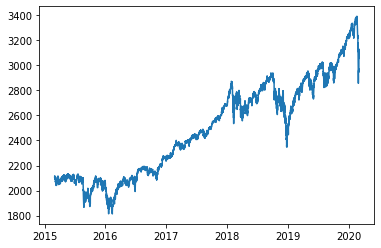

In [94]:
plt.plot(SandP_df['TIMESTAMP'], SandP_df['CLOSE'])
plt.show()

# Get subset of test data

In [143]:
# for testing, get subset of data for 4th-11th Jan 2017

test_data = SandP_df.loc[(SandP_df['DATE'] == '2017-01-04') ]
test_data

,DATE,TIMESTAMP,OPEN,HIGH,LOW,CLOSE,VOL
16885,2017-01-04,2017-01-04 09:35:00,2261.60,2266.89,2261.60,2266.75,264
16886,2017-01-04,2017-01-04 09:40:00,2266.90,2268.46,2264.94,2264.94,262
16887,2017-01-04,2017-01-04 09:45:00,2264.92,2266.92,2264.63,2264.66,265
16888,2017-01-04,2017-01-04 09:50:00,2264.67,2266.37,2264.67,2265.65,257
16889,2017-01-04,2017-01-04 09:55:00,2265.67,2266.98,2265.67,2266.74,259
...,...,...,...,...,...,...,...
16959,2017-01-04,2017-01-04 15:45:00,2272.15,2272.82,2272.13,2272.15,194
16960,2017-01-04,2017-01-04 15:50:00,2272.16,2272.55,2270.09,2270.18,229
16961,2017-01-04,2017-01-04 15:55:00,2270.17,2271.03,2270.17,2270.71,219
16962,2017-01-04,2017-01-04 16:00:00,2270.78,2271.42,2269.68,2270.50,203


# Functions

## Find lag $J$


In [115]:
def compute_lag(data, plot = False):

    autocorr = acf(data, fft = True, nlags = 500)

    if (plot):
        plt.plot(autocorr)
        plt.axhline(1 - 1/np.e, linestyle = "--", c = 'k', label = '1-1/e')
        plt.legend(loc = 'best')
        
    i = 0
        
    while (autocorr[i] > (1-1/np.e)):
        lag = autocorr[i]
        i += 1
        
    if (plot):
        plt.axvline(i)

    return i

7

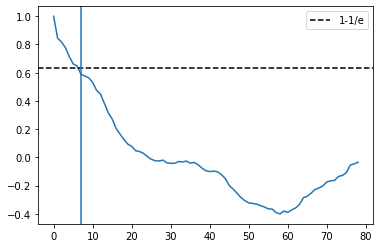

In [123]:
test_data = test_data.loc[test_data['DATE'] == '2017-01-04']
compute_lag(test['OPEN'], plot = True)

## Embedding dimension $m$
- Time series is 1 dimensional therefore m > 2
- Do multiple tests to assess best embedding dimension
- Rich working on Cao's method


In [124]:
def compute_embedding_dimension():
    return 2

## Calculate mean period $\mu$

In [126]:
def compute_mean_period (timeseries):
    power_spectrum = periodogram(timeseries)[1]
    frequencies = periodogram(timeseries)[0]

    
    weights = power_spectrum / sum(power_spectrum)
    return 1/np.average(frequencies, weights = weights)

## Encode into phase space

In [174]:
def gen_phase_space_matrix(timeseries, J, m):
    
    timeseries = timeseries.to_list()
    
    matrix = pd.DataFrame(columns = np.arange(0,m))
        
    for i, val in enumerate(timeseries):
        
        x_i = []

        for it in range(0, m):
            
            try:
                i_plus_j = timeseries[i + J*it]
                x_i.append(i_plus_j)
            except:
                x_i.append(np.nan)
                
        
        matrix.loc[i] = x_i
    return matrix

## Find initial nearest neighbours

In [271]:
def euc_distance (p1, p2):
    
    try: 
        return distance.euclidean (p1,p2)
    except:
        return np.inf

In [276]:
def find_nearest_neighbour (dataframe, ref_index, mean_period, i_max = 5):
    
    dists = []
    ref_row = dataframe.iloc[ref_index, :].values
    
    for i in range(0,dataframe.shape[0] - i_max):
        
        test_row = dataframe.iloc[i, :].values
        
#         print("")
#         print("i = ", i, " ref = ", ref_index, " diff = ", abs(i-ref_index)," mean period = ", mean_period )
                
        if i != ref_index and abs(i-ref_index) > mean_period:
            
#             print("ref = ", ref_row)
#             print("test = ", test_row)

            dist = euc_distance(ref_row, test_row)
        else:
            dist = np.inf
       
        #print('dist = ', dist)
        dists.append(dist)
        
    dists = pd.DataFrame(dists,columns = ['euc_distance'])
    dists = dists.sort_values(by = 'euc_distance', ascending = True)    
    
    
    if (dists.head(1)['euc_distance'].values  == np.inf):
        print('Nearest neighbour not found for index ', ref_index)
        return np.nan
    else:
        return dists.head(1).index.values[0]

## Compute divergence


In [182]:
def compute_divergence(dataframe, NN_pairs, i_max = 5): 
    
    dj_data = []
    
    for i in range (0,i_max): # calculate divergence through i_max steps
        
        dj_i = []
    
        for k in range (0,(dataframe.shape[0] - i_max)): # compute for all nearest neighbour pairs 
            
            NN_1 = NN_pairs[k][0]
            NN_2 = NN_pairs[k][1]
            
            p1 = dataframe.iloc[NN_1 + i, :]
            p2 = dataframe.iloc[NN_2 + i, :]
            
            dj_i.append(euc_distance(p1,p2))
                
        
        dj_data.append([i,np.mean(np.log(dj_i))])
        

    return dj_data

# Apply to data series

In [329]:
def calc_daily_lyapunov_exponent(dataframe, date, column = "OPEN", i_max = 5, plot = False):
    
    regressor = LinearRegression()  
    
    time_series = dataframe.loc[dataframe["DATE"] == date][column]
        
    J = compute_lag(time_series, plot = False)
    m = compute_embedding_dimension()
    mu = compute_mean_period(time_series)
    
    print("Date = ", date)
    print("")
    
    print("lag J = ", J)
    print("embedding dimension m = ", m)
    print("period mu = ", mu)
    
    matrix = gen_phase_space_matrix(time_series, J, m)
    matrix = matrix.dropna() ## drop rows that are missing a phase space co-ord (due to lag taking past end of list)
        
    NN_pairs = []

    for i in range(0,matrix.shape[0]):
        NN = find_nearest_neighbour(matrix, ref_index= i, mean_period = mu, i_max = i_max)
        NN_pairs.append([i,NN])
        
    lyaponov_data = pd.DataFrame(compute_divergence(matrix, NN_pairs, i_max = i_max), columns = ['i','log(dj)'])
    
    
    y = lyaponov_data['log(dj)'].values.reshape(-1,1)
    x = lyaponov_data['i'].values.reshape(-1,1)
    
    regressor.fit(x,y)
    
    fit = regressor.predict(x) 
    
    slope = regressor.coef_[0][0]
    error = metrics.mean_absolute_error(y, fit)  
    r_squared = metrics.r2_score(y,fit)

    print("")

    print("Lyapunov exponent = ", slope, "+/-", error)
    print("R squared = ", r_squared)
                           
    
    if (plot):
        lyaponov_data.plot(x = 'i', y = 'log(dj)')
        plt.plot (x, fit, c = 'k')
        plt.ylabel("log dj")
        plt.xlabel("i")

    
    return lyaponov_data

Date =  2017-01-04

lag J =  7
embedding dimension m =  2
period mu =  15.939631609628501

Lyapunov exponent =  0.16158644885250661 +/- 0.08363245774175092
R squared =  0.830285383853922


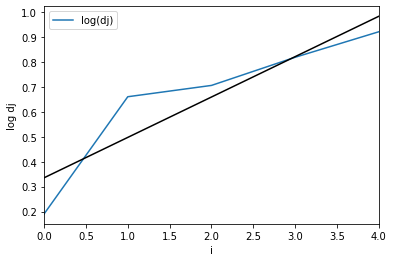

In [331]:
test = calc_daily_lyapunov_exponent(SandP_df, '2017-01-04', i_max = 5, plot = True)

Date =  2017-01-04

lag J =  7
embedding dimension m =  2
period mu =  15.939631609628501

Lyapunov exponent =  0.16158644885250661 +/- 0.08363245774175092
R squared =  0.830285383853922


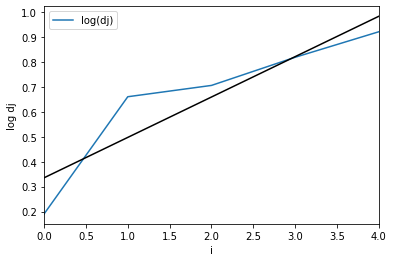

In [331]:
test = calc_daily_lyapunov_exponent(SandP_df, '2017-01-04', i_max = 5, plot = True)